In [81]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import NegativeClassOptimization.config as config

In [82]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [83]:
folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}

In [84]:
cmap = { 'vs 9' : '#FF5733',
         'vs 9 negatives' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Non-binder negatives':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs Weak negatives':'#FFC300',
         'vs 1': '#8B5F4D',
         'vs 1 negatives': '#8B5F4D',
         'binder':'#EC8D78'}

In [85]:
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy

In [86]:
#func calculate shannon entropy from position weight matrixes
def entropy_slides(slides):

    # Create a list of Seq objects
    seqs = [Seq(slide) for slide in slides]

    # Create a motifs instance
    m = motifs.create(seqs, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm: np.ndarray = pd.DataFrame(m.pwm).values

    pwm += 1e-20  # Avoid log(0)

    # Compute entropy of a position-weight matrix
    return entropy(pwm, axis=1, base=2).sum()
    # return -np.sum(pwm * np.log(pwm), axis=1).sum()  # Same as entropy, checkedPositive antigen



In [87]:
paths = {'high_low_concat': ['high_95low', 'high_looser'], '1_vs_all' : ['vs_all']} #needs changing

In [88]:
res = []
energies = []
for ag in config.ANTIGENS:
    for root, folders in paths.items():
        for folder in folders:
            df = pd.read_csv(config.DATA_BASE_PATH/f'full_data/{root}/{ag}_{folder}.tsv', sep='\t')
            ent = entropy_slides(df[df['binder'] == False]['Slide'].values)
            #ent = entropy_slides(df['Slide'].values)
            res.append([ag, folder, ent])

In [89]:
df_entropy_full = pd.DataFrame(res, columns=['antigen', 'task', 'entropy'])

In [90]:
full_folder_2_task = {'high_95low': 'vs Non-binder', 'high_vs_95low': 'vs Non-binder', 'high_looser': 'vs Weak','high_vs_looser': 'vs Weak', '1v9': 'vs 9', 'vs_all': 'vs 9'}
df_entropy_full['task'] = df_entropy_full['task'].apply(lambda x: full_folder_2_task[x])

In [91]:
hue_order = ['vs Weak', 'vs 9', 'vs Non-binder']

In [93]:
"""
folders = ['1v9', 'high_vs_95low', 'high_vs_looser']
res15000 = []
for ag in config.ANTIGENS:
    for folder in folders_15000:
        path_ = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_42/{ag}*/*_train_dataset.tsv')[0]"""


def combine_task_df(ag):
    #let's take only train data
    path_vs9 = glob.glob(str(config.DATA_BASE_PATH/f'Frozen_MiniAbsolut_ML/1v9/seed_0/split_42/{ag}*/*_train_dataset.tsv'))[0]
    df_high = pd.read_csv(path_vs9, sep="\t")
    df_binder = df_high[df_high['y'] == 1]
    df_binder['Antigen'] = ag
    df_vs9 = df_high[df_high['y'] == 0]
    df_vs9['task'] = 'vs 9 negatives' #only negative part
    df_vs9['Antigen'] = ag
    df_binder['task'] = 'binder'
    path_looser = glob.glob(str(config.DATA_BASE_PATH/f'Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_42/{ag}*/*_train_dataset.tsv'))[0]
    df_looser = pd.read_csv(path_looser, sep="\t")
    df_looser = df_looser[df_looser['y'] == 0]
    df_looser['task'] = 'vs Weak negatives'
    df_looser['Antigen'] = ag
    path_95low = glob.glob(str(config.DATA_BASE_PATH/f'Frozen_MiniAbsolut_ML/high_vs_95low/seed_0/split_42/{ag}*/*_train_dataset.tsv'))[0]
    df_95low = pd.read_csv(path_95low, sep="\t")
    df_95low = df_95low[df_95low['y'] == 0]
    df_95low['task'] = 'vs Non-binder negatives'
    df_95low['Antigen'] = ag
    df_ag = pd.concat([df_binder, df_vs9, df_looser, df_95low])
    return df_ag

df_slides_by_class = pd.DataFrame()
for ag in config.ANTIGENS:
    df_ag = combine_task_df(ag)
    if ag == '5E94':
        df_ag['Antigen'] = '5E94'
    df_slides_by_class = pd.concat([df_slides_by_class.reset_index(drop=True), df_ag.reset_index(drop=True)], axis=0)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70457/2852045801.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binder['Antigen'] = ag
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70457/2852045801.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vs9['task'] = 'vs 9 negatives' #only negative part
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70457/2852045801.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [15]:
df_ent_train_by_class = []
for ag in config.ANTIGENS:
    for task in ['binder', 'vs Non-binder negatives', 'vs Weak negatives', 'vs 9 negatives']:
        df_ = df_slides_by_class[(df_slides_by_class['Antigen'] == ag) & (df_slides_by_class['task'] == task)]
        ent = entropy_slides(df_.Slide.values)
        df_ent_train_by_class.append([ag, task, ent])
df_ent_train_by_class = pd.DataFrame(df_ent_train_by_class, columns=['ag', 'task', 'ent'])
df_ent_train_by_class.rename(columns={'ag':'antigen'}, inplace=True)


Text(0.5, 1.0, 'Entropy of train slides by data class')

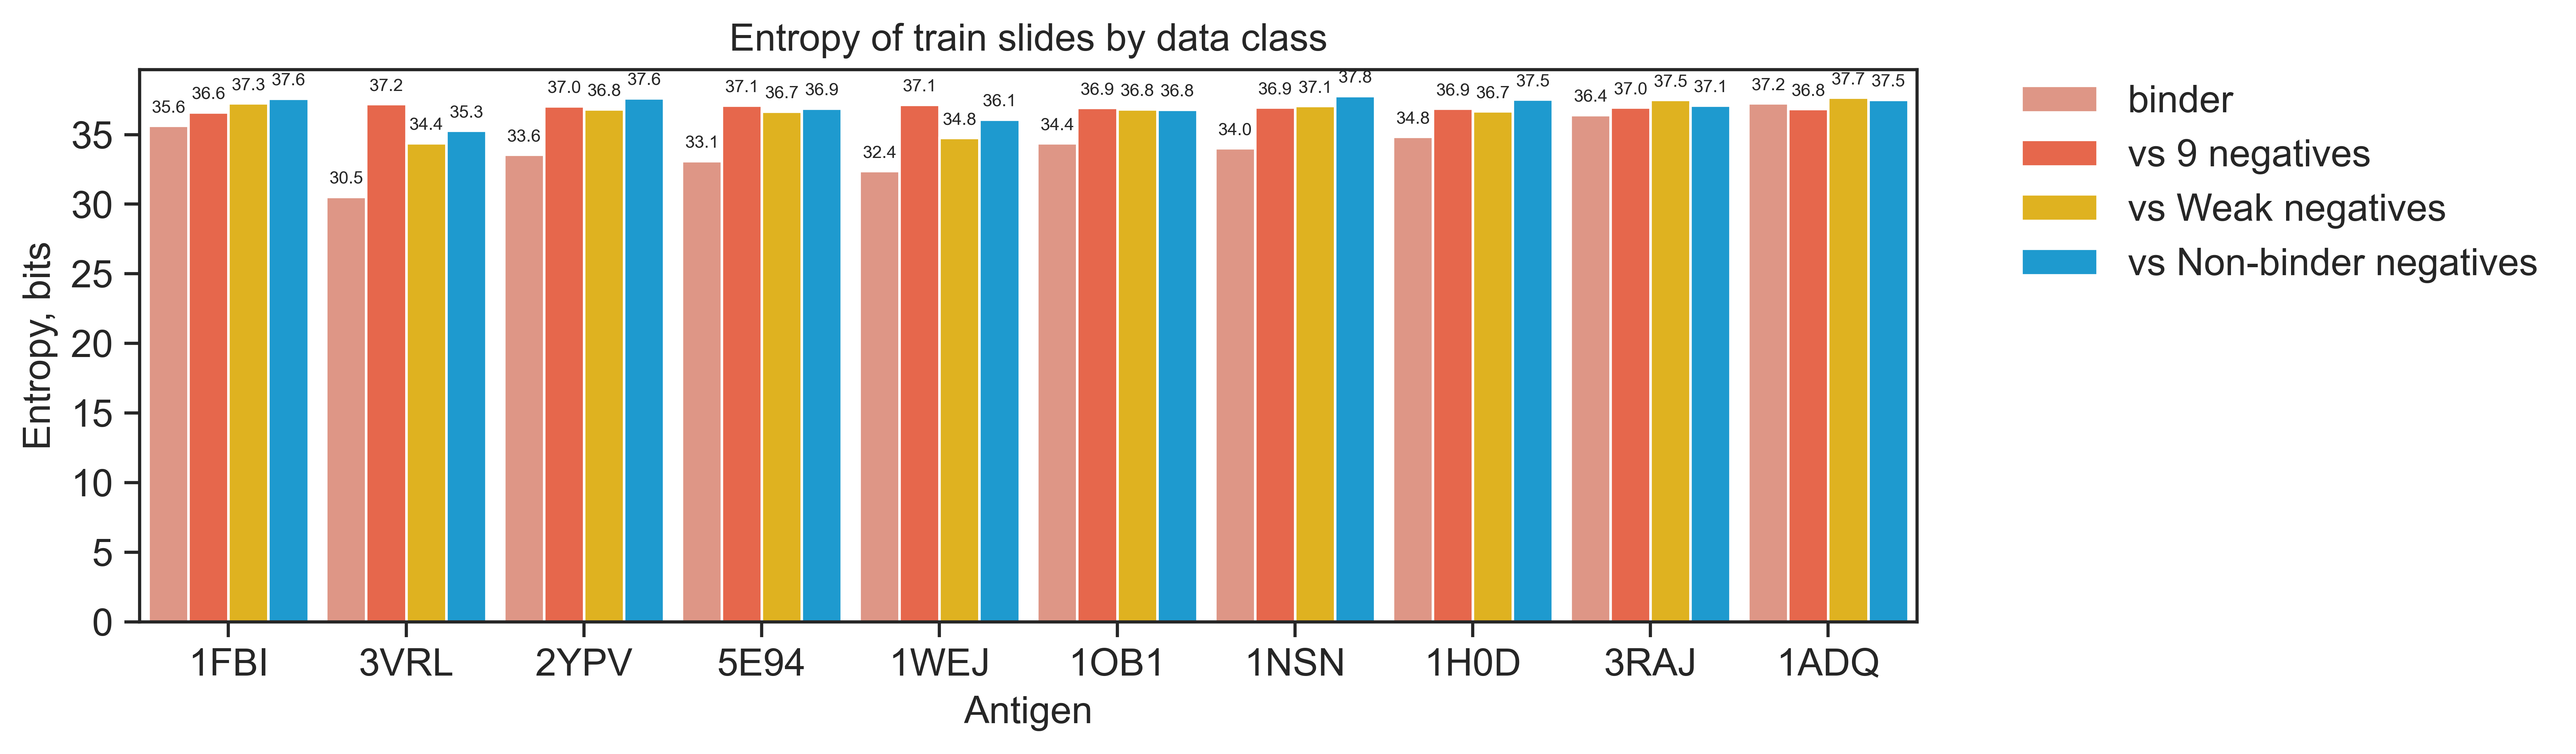

In [16]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_theme(context="paper")
#sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3.2*3.14, 3.14), dpi=600)

sns.barplot(
    x="antigen",
    y="ent",
    hue="task",
    data=df_ent_train_by_class,
    order=ag_order,
    palette=cmap,
    hue_order = ['binder','vs 9 negatives', 'vs Weak negatives', 'vs Non-binder negatives'],
    ax=ax,
    width=0.9,
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))
# Title
ax.set_title("Entropy of train slides by data class", fontsize=FONT_SIZE)
#move legend bellow
#fig.savefig('./figures/overall_entropies.svg')

### Subfigure a

In [17]:
folders_15000 = ['1v9', 'high_vs_95low', 'high_vs_looser']
res15000 = []
for ag in config.ANTIGENS:
    for folder in folders_15000:
        path_ = glob.glob(str(config.DATA_BASE_PATH/f'Frozen_MiniAbsolut_ML/{folder}/seed_0/split_42/{ag}*/*_train_dataset.tsv'))[0]
        df = pd.read_csv(path_, sep='\t')
        #ent = entropy_slides(df[df['y'] ==0]['Slide'].values)
        ent = entropy_slides(df['Slide'].values)
        res15000.append([ag, folder, ent])
        
df_entropy_train = pd.DataFrame(res15000, columns=['antigen', 'task', 'entropy']) #entripy of positive and negative data conbined
df_entropy_train['task'] = df_entropy_train['task'].apply(lambda x: full_folder_2_task[x])

Text(0.5, 1.0, 'Entropy of train slides')

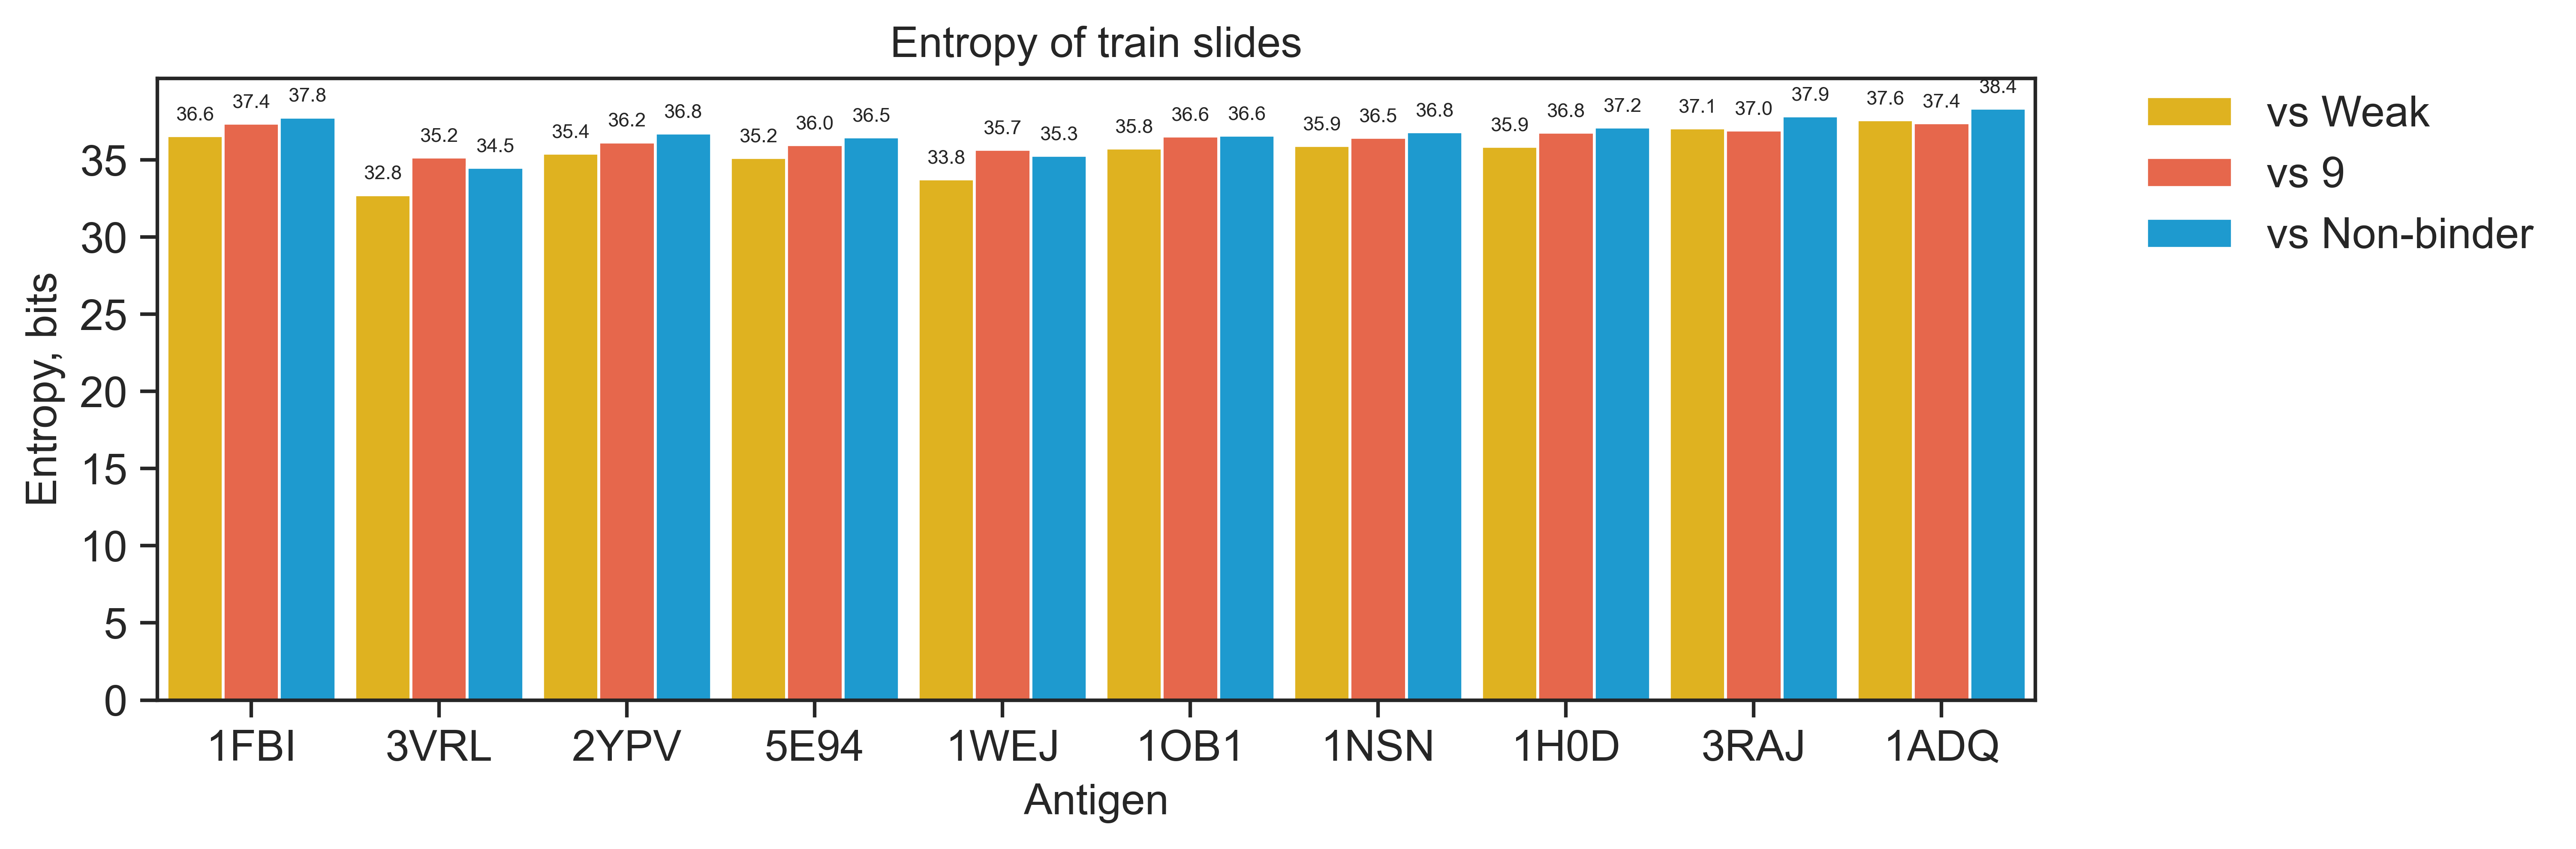

In [18]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_theme(context="paper")
#sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3*3.14, 3.14), dpi=600)

sns.barplot(
    x="antigen",
    y="entropy",
    hue="task",
    data=df_entropy_train,
    order=ag_order,
    palette=cmap,
    ax=ax,
    hue_order = hue_order,
     width=0.9
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))

# Title
ax.set_title("Entropy of train slides", fontsize=FONT_SIZE)
#fig.savefig('./figures/overall_entropies.svg')

In [23]:
perf_df = pd.read_csv(config.DATA_BASE_PATH/'openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak','ONE_VS_ONE': 'vs 1' }
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])
df_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [24]:
df_closed_focused = df_closed[(df_closed['split_id'] == '42') & (df_closed['seed_id'] == '0')][['acc', 'train_task', 'train_ag']]

In [25]:
df_closed_focused.rename(columns={'train_task':	'task','train_ag':'antigen'}, inplace=True)

In [26]:
df_entropy_train = df_entropy_train.merge(df_closed_focused, on=['task', 'antigen'])


In [27]:
res15000_vs1 = []
for ag in config.ANTIGENS:
    negs = set(config.ANTIGENS)
    negs.discard(ag)
    for ag_neg in negs:
        path_ = glob.glob(str(config.DATA_BASE_PATH/f'Frozen_MiniAbsolut_ML/1v1/seed_0/split_42/{ag}__vs__{ag_neg}/*_train_dataset.tsv'))[0]
        df = pd.read_csv(path_, sep='\t')
        #ent = entropy_slides(df[df['y'] ==0]['Slide'].values)
        ent = entropy_slides(df['Slide'].values)
        res15000_vs1.append([ag, ag_neg, 'vs 1', ent])

In [28]:
df_entropy_train_vs1 =  pd.DataFrame(res15000_vs1, columns=['train_ag', 'train_neg', 'task', 'entropy'])


In [29]:
df_1vs1_perf = pd.read_csv(config.DATA_BASE_PATH/'1vs1_perf.tsv', sep='\t', index_col=0)

In [30]:
df_1vs1_perf = df_1vs1_perf[(df_1vs1_perf['seed_id'] == 0) & (df_1vs1_perf['split_id'] == 42)]

In [31]:
df_entropy_train_vs1 = df_entropy_train_vs1.merge(df_1vs1_perf, on=['train_ag', 'train_neg'])

In [32]:
df_entropy_train_vs1_sq = df_entropy_train_vs1.pivot(index='train_ag', columns='train_neg', values='entropy').loc[ag_order][ag_order]
mask = np.triu(df_entropy_train_vs1_sq)

<AxesSubplot:xlabel='train_neg', ylabel='train_ag'>

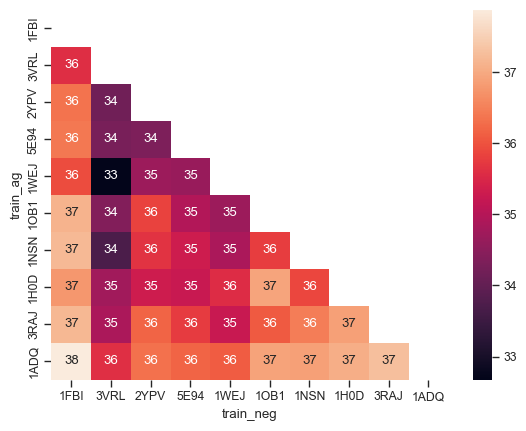

In [33]:
plt.rcParams['svg.fonttype'] = 'none'
sns.heatmap(df_entropy_train_vs1_sq, annot=True, mask=mask)
#plt.savefig('./figures/vs1_entropy.svg')

### Subfigure B

In [34]:
from scipy.stats import pearsonr

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70457/2626845232.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


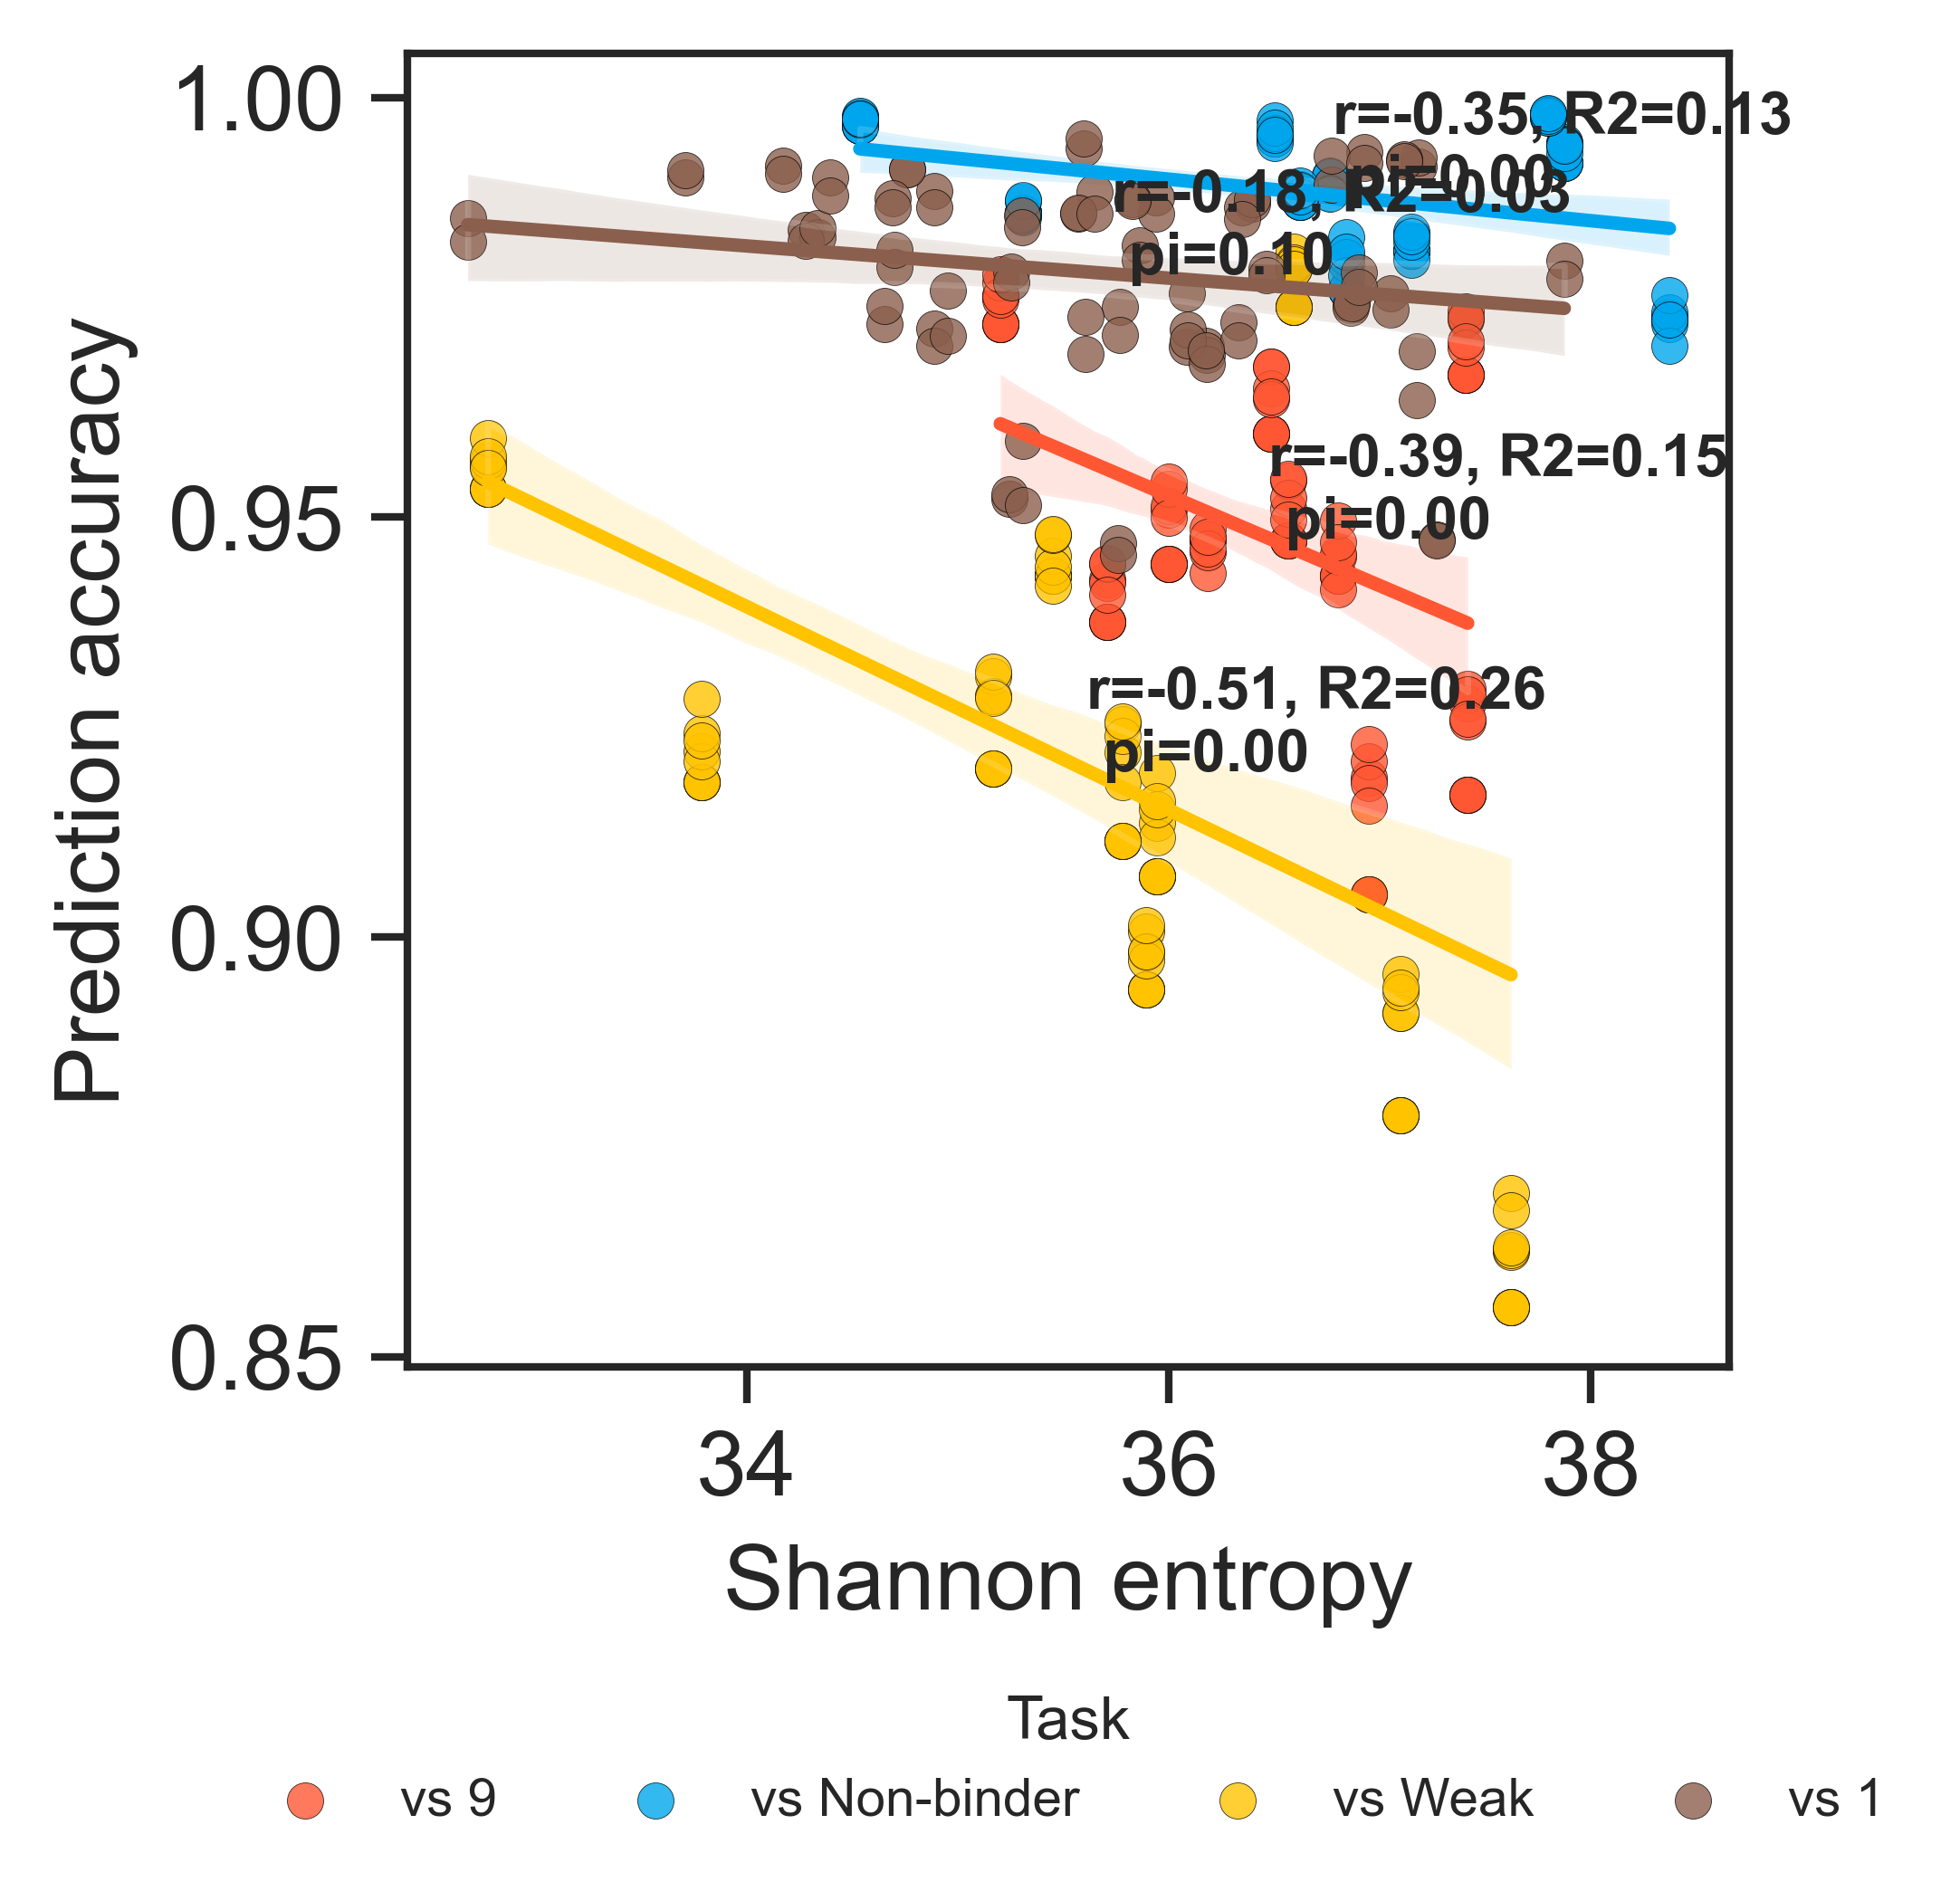

In [35]:
plt.rcParams['svg.fonttype'] = 'none'
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in df_entropy_train.groupby("task"):
    sns.regplot(
        x="entropy",
        y="acc",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["entropy"], df_g["acc"])
    # Add text with r and R2 at centroid
    x = df_g["entropy"].mean()
    y = df_g["acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=8, fontweight="bold")

sns.regplot(
        x="entropy",
        y="acc",
        data=df_entropy_train_vs1,
        scatter=True,
        ax=ax,
        label='vs 1',
        color=cmap['vs 1'],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}
    )
r, pval = pearsonr(df_entropy_train_vs1["entropy"], df_entropy_train_vs1["acc"])
# Add text with r and R2 at centroid
x = df_entropy_train_vs1["entropy"].mean()
y = df_entropy_train_vs1["acc"].mean()
ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=8, fontweight="bold")



FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

ax.set_xlabel("Shannon entropy", fontsize=FONT_SIZE)
ax.set_ylabel('Prediction accuracy', fontsize=FONT_SIZE)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
#plt.savefig('./figures/sh_entropy_id_accuracy.svg')


In [67]:
df_ent_train_by_class_acc = df_ent_train_by_class[df_ent_train_by_class['task'] != 'binder']

In [68]:
df_ent_train_by_class_acc['task'] = df_ent_train_by_class_acc.task.apply(lambda x: ' '.join(x.split(' ')[:-1]))

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_70318/3466526232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent_train_by_class_acc['task'] = df_ent_train_by_class_acc.task.apply(lambda x: ' '.join(x.split(' ')[:-1]))


In [69]:
df_ent_train_by_class_acc = df_ent_train_by_class_acc.merge(df_closed_focused, on=['task', 'antigen'])

### Subfigure C

In [44]:
df_jsd = pd.read_csv('../jsd_section1.csv', index_col=0)
df_jsd_vs1 = df_jsd[df_jsd['train_task'] == 'vs 1']
df_jsd = df_jsd[df_jsd['train_task'] != 'vs 1']

In [49]:
df_jsd_pivoted = df_jsd.pivot_table(columns='train_task', values='jsd', index='train_ag')
df_jsd_pivoted

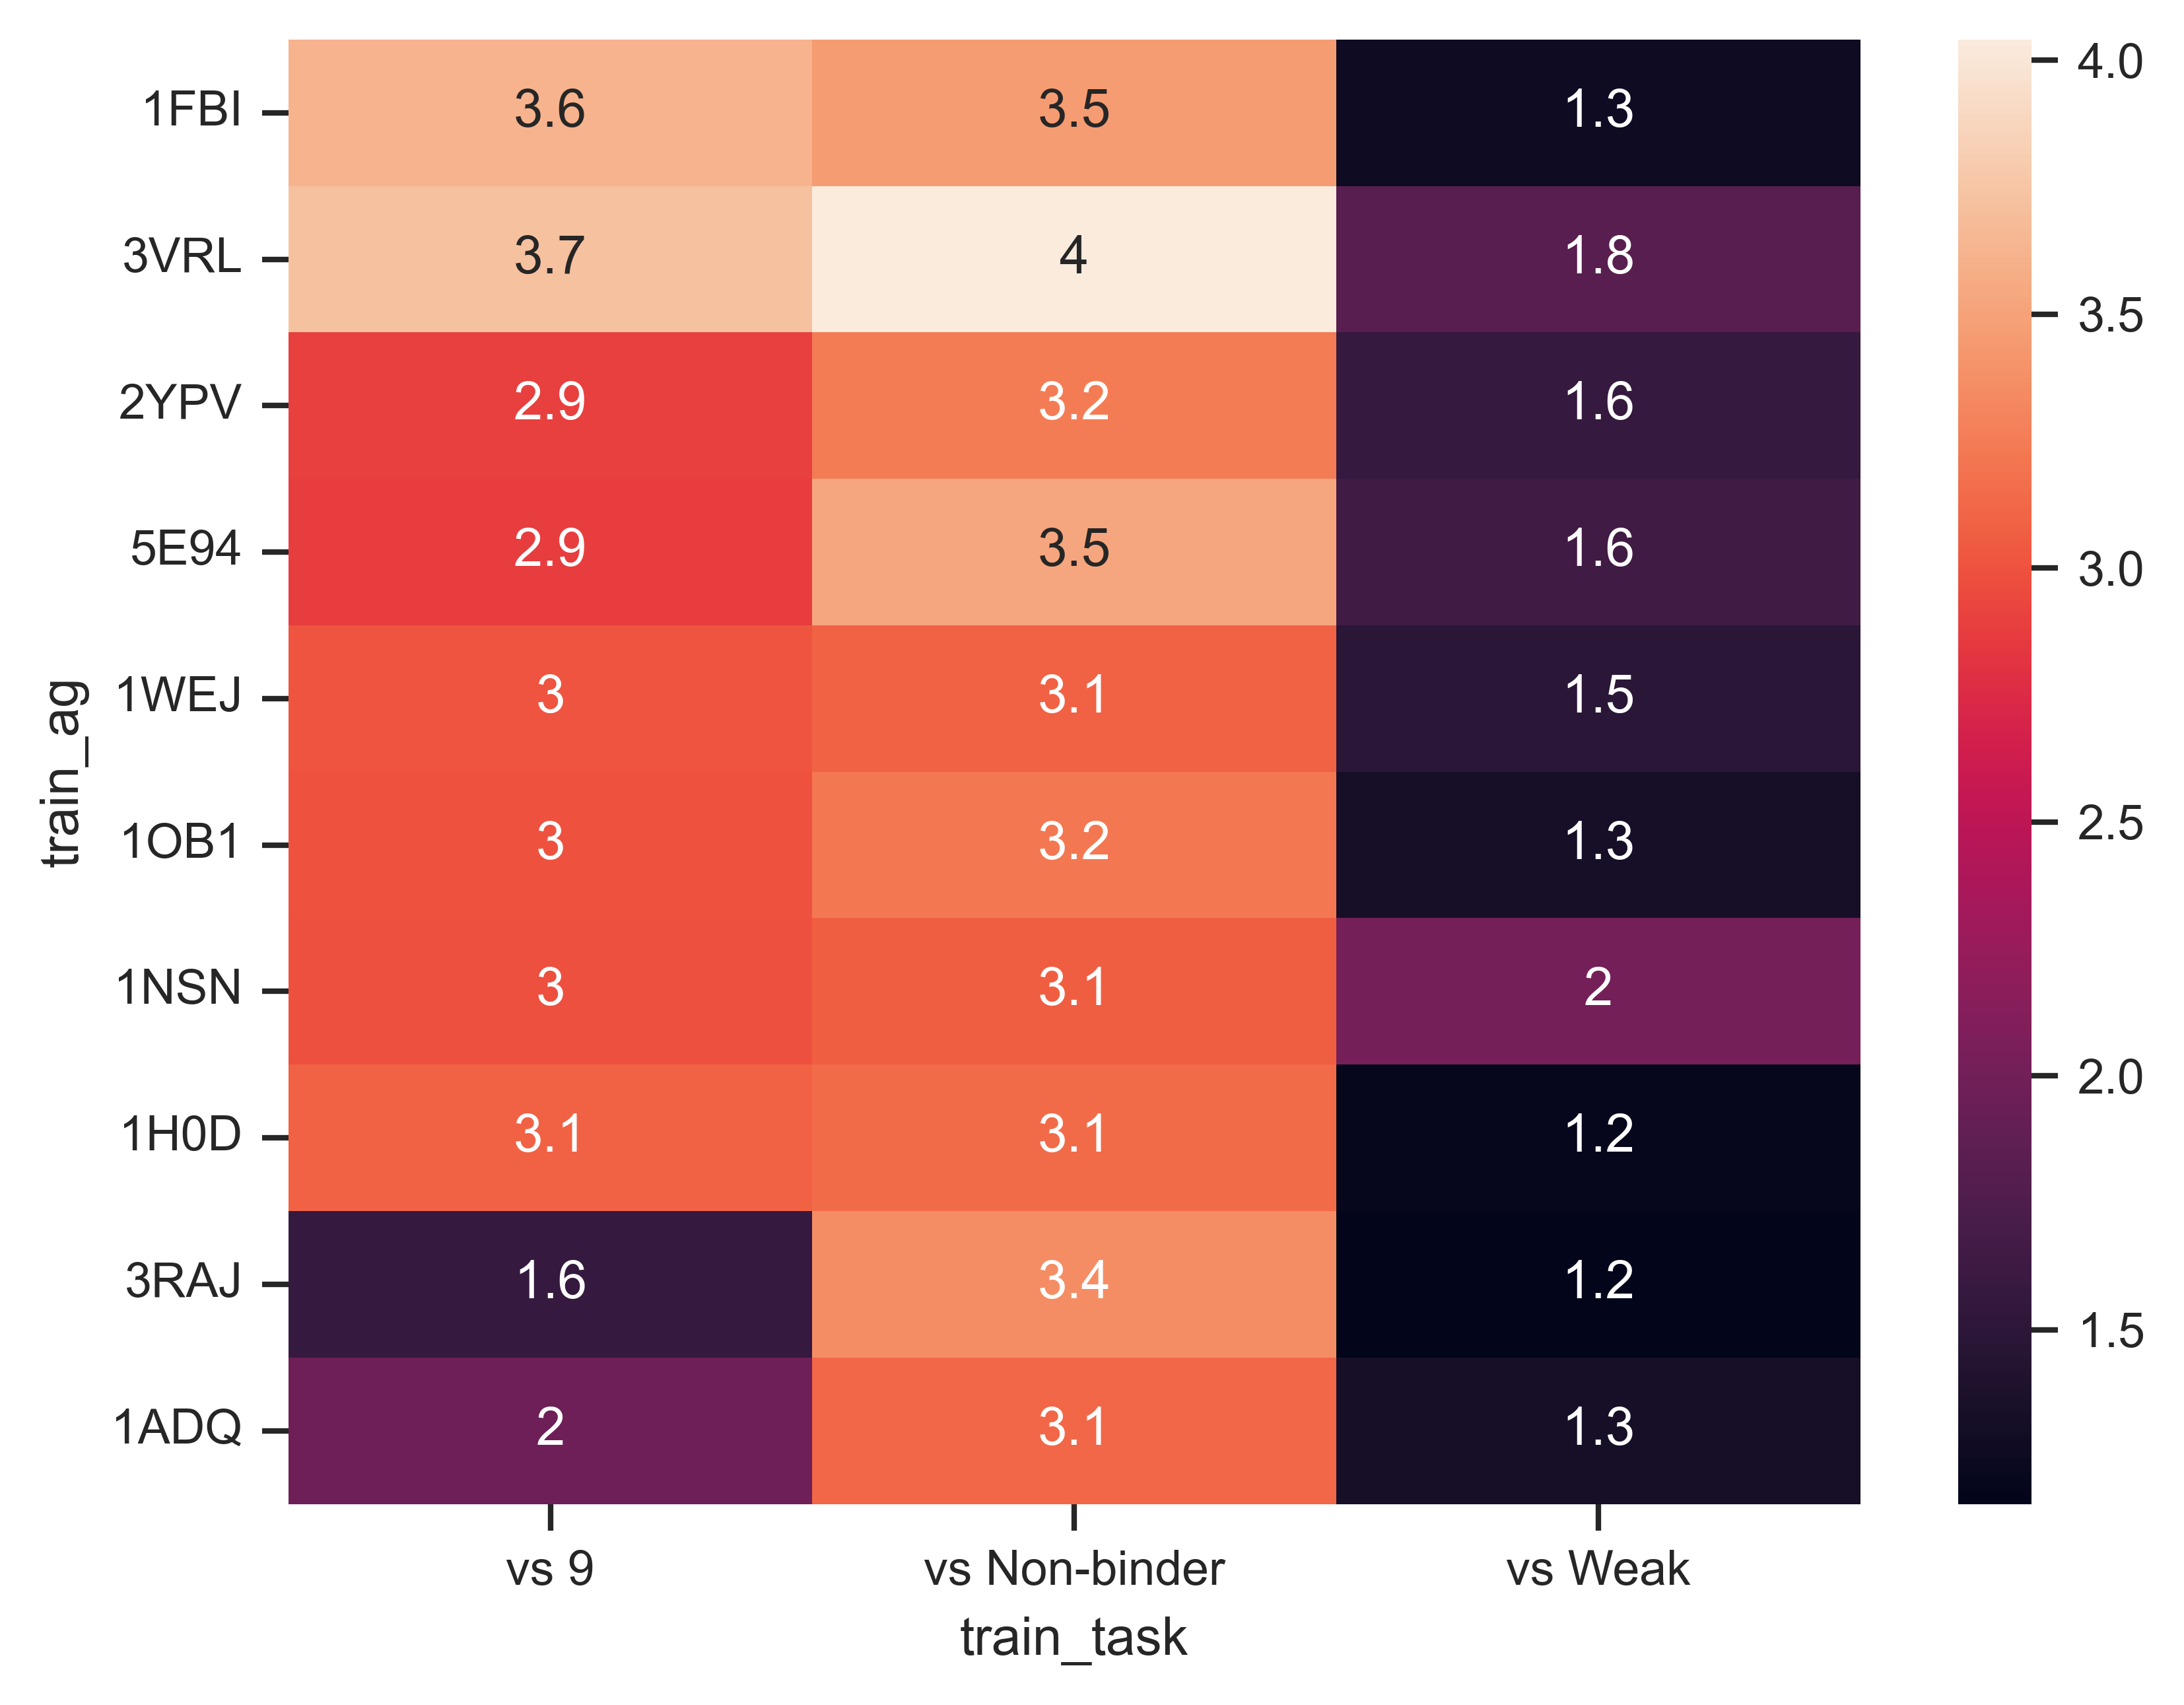

In [61]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(dpi=600)
sns.heatmap(df_jsd_pivoted.loc[ag_order], ax=ax, annot=True)
ax.tick_params(axis='y', labelrotation=0)

In [62]:
df_jsd_vs1

,train_task,jsd,acc,train_ag,train_neg,seed,split
300,vs 1,4.750259,0.9941,1H0D,1OB1,2,42
301,vs 1,4.750259,0.9943,1OB1,1H0D,2,42
302,vs 1,3.041810,0.9752,1ADQ,2YPV,2,42
303,vs 1,4.053069,0.9887,1NSN,1WEJ,2,42
304,vs 1,3.476879,0.9716,3RAJ,1FBI,2,42
...,...,...,...,...,...,...,...
1195,vs 1,3.241361,0.9703,2YPV,3RAJ,0,1
1196,vs 1,2.936188,0.9444,3RAJ,5E94,0,1
1197,vs 1,3.802060,0.9837,1H0D,1NSN,0,1
1198,vs 1,4.200919,0.9708,3VRL,1ADQ,0,1


In [71]:
df_jsd_vs1_pivoted = df_jsd_vs1.pivot_table(columns='train_neg', values='jsd', index='train_ag')
df_jsd_vs1_pivoted = df_jsd_vs1_pivoted.loc[ag_order][ag_order]

In [72]:
mask = np.triu(df_jsd_vs1_pivoted)

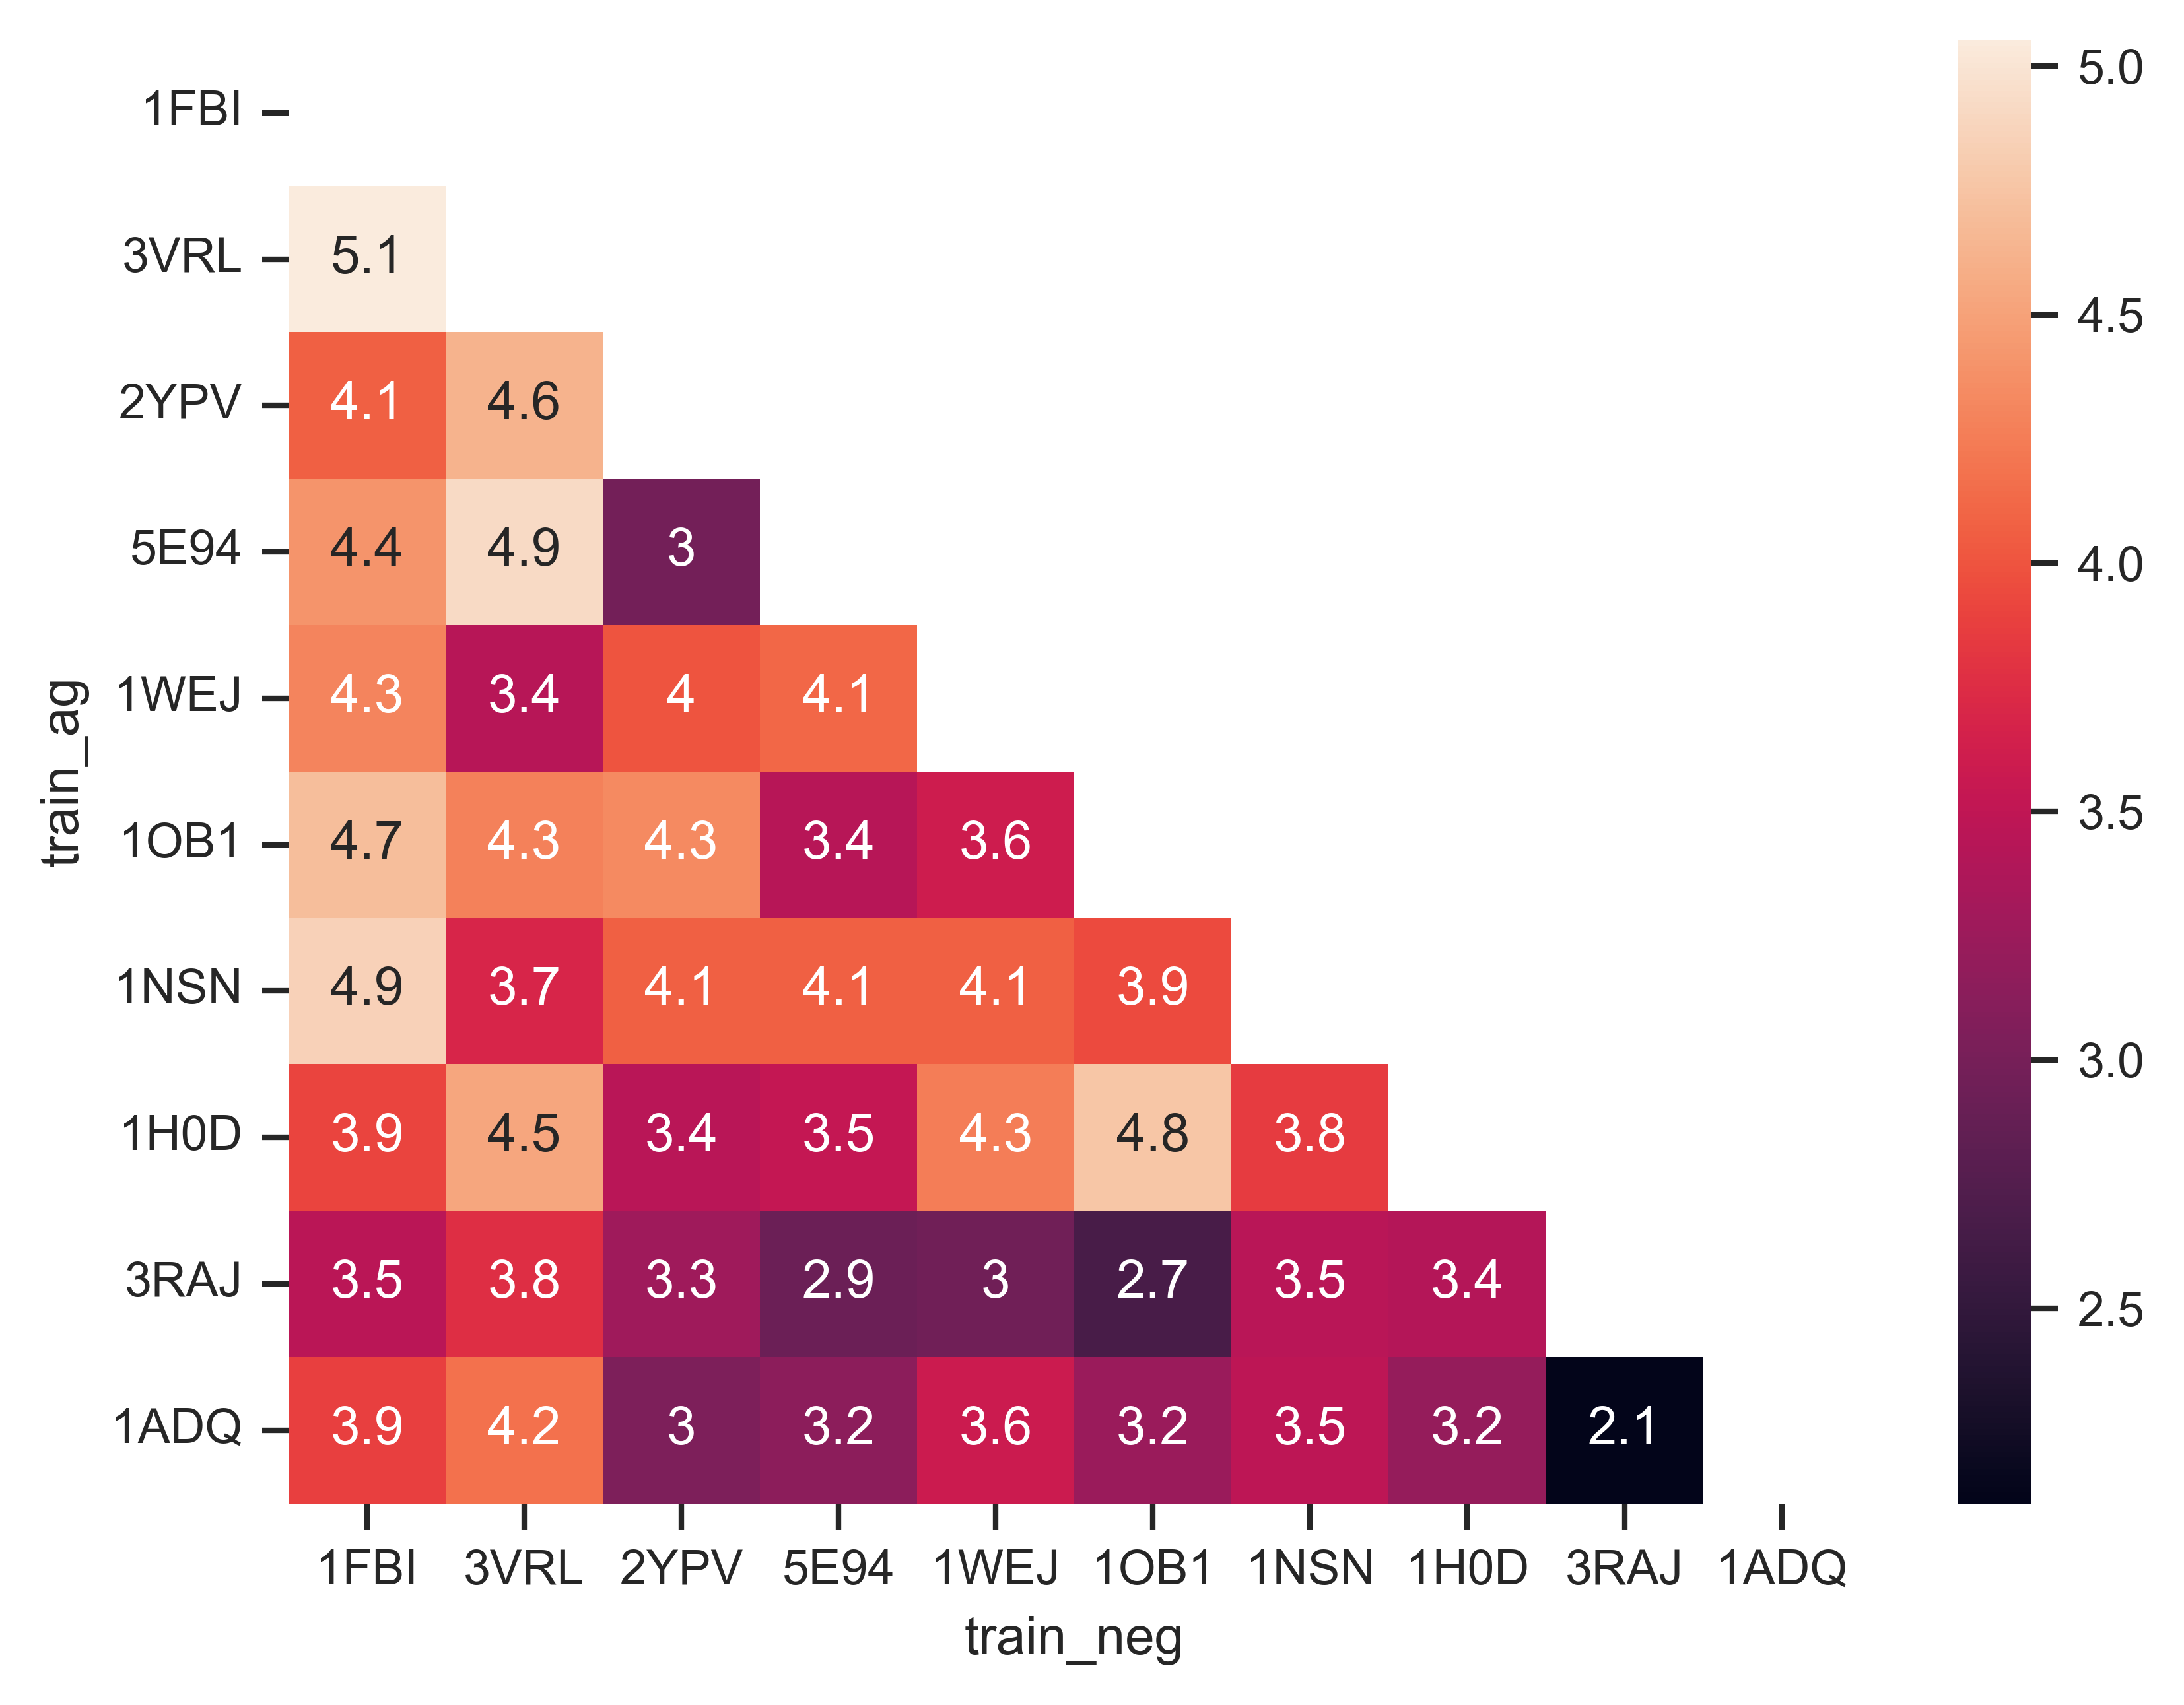

In [73]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(dpi=600)
sns.heatmap(df_jsd_vs1_pivoted.loc[ag_order], ax=ax, annot=True, mask=mask)
ax.tick_params(axis='y', labelrotation=0)